In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))

import numpy as np
import pandas as pd

import resspect
from resspect.tom_client import TomClient
from oracle_resspect_classifier.elasticc2_oracle_feature_extractor import ELAsTiCC2_ORACLEFeatureExtractor

/global/homes/a/arjun15/.conda/envs/resspect/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda device


In [ ]:
import itertools

# code to grab objects from TOM for testing - not the most optimal way to do this but a good check for whether the feature extractor is doing its job
username = 'arjun15'
passwordfile = '../../oracle/passwordfile'

detected_in_last_days = 1
mjd_now = 60800
num_objects = 5


tom = TomClient(url="https://desc-tom-2.lbl.gov", username=username, passwordfile=passwordfile)

dic = {
    'detected_in_last_days': detected_in_last_days,
    'mjd_now': mjd_now
}

res = tom.post('elasticc2/gethottransients', json=dic)
data = res.json() if res.status_code == 200 else {}
print('=> Fetched hot transients')

ids = [obj['objectid'] for obj in data['diaobject']]
ids = ids[:num_objects] if len(ids) > num_objects else ids

# using these object ids, load in static and time series data for ORACLE
static = tom.post('db/runsqlquery/',
                json={'query': '''SELECT diaobject_id, ra, decl, mwebv, mwebv_err, z_final, z_final_err, hostgal_zphot, hostgal_zphot_err,
                hostgal_zspec, hostgal_zspec_err, hostgal_ra, hostgal_dec, hostgal_snsep, hostgal_ellipticity, hostgal_mag_u,
                hostgal_mag_g, hostgal_mag_r, hostgal_mag_i, hostgal_mag_z, hostgal_mag_y FROM elasticc2_ppdbdiaobject WHERE diaobject_id IN (%s) ORDER BY diaobject_id;''' % (', '.join(str(id) for id in ids)),
                    'subdict': {}})
static_data = static.json() if static.status_code == 200 else {}
print('=> Loaded static data...')

ts = tom.post('db/runsqlquery/',
                json={'query': 'SELECT diaobject_id, midpointtai, filtername, psflux, psfluxerr FROM elasticc2_ppdbdiaforcedsource WHERE diaobject_id IN (%s) ORDER BY diaobject_id;' % (', '.join(str(id) for id in ids)),
                    'subdict': {}})
ts_data = ts.json() if ts.status_code == 200 else {}
print('=> Loaded time-series data...') 

assert ts_data['status'] == 'ok', 'Failed to retrieve data from TOM!'

# for each object, sort all observations by MJD
ts_data['rows'].sort(key=lambda obs: obs['diaobject_id'])
grouped_ts_data = {snid: list(obj) for snid, obj in itertools.groupby(ts_data['rows'], key=lambda obs: obs['diaobject_id'])}

for observation in grouped_ts_data.values():
    observation.sort(key=lambda obs: obs['midpointtai'])

print(ts_data)
print(static_data)

In [2]:
import polars as pl

nersc_parquet_files = '/global/cfs/cdirs/desc-td/ELASTICC2_TRAIN02_parquet'
parquet_example = os.path.join(nersc_parquet_files, 'SNIc+HostXT_V19.parquet')
parquet = pl.read_parquet(parquet_example)

In [3]:
example_input = parquet[:10]
# example_snid = 487573  # Replace with the desired SNID value
# example_input = parquet.filter(pl.col('SNID') == example_snid)
example_input

SNID,MJD,BAND,PHOTFLAG,PHOTPROB,FLUXCAL,FLUXCALERR,PSF_SIG1,SKY_SIG,RDNOISE,ZEROPT,ZEROPT_ERR,GAIN,SIM_MAGOBS,RA,DEC,SNTYPE,NOBS,PTROBS_MIN,PTROBS_MAX,MWEBV,MWEBV_ERR,REDSHIFT_HELIO,REDSHIFT_HELIO_ERR,REDSHIFT_FINAL,REDSHIFT_FINAL_ERR,VPEC,VPEC_ERR,HOSTGAL_NMATCH,HOSTGAL_NMATCH2,HOSTGAL_OBJID,HOSTGAL_FLAG,HOSTGAL_PHOTOZ,HOSTGAL_PHOTOZ_ERR,HOSTGAL_SPECZ,HOSTGAL_SPECZ_ERR,HOSTGAL_RA,…,SIM_REDSHIFT_HELIO,SIM_REDSHIFT_CMB,SIM_REDSHIFT_HOST,SIM_REDSHIFT_FLAG,SIM_VPEC,SIM_HOSTLIB_GALID,SIM_HOSTLIB(LOGMASS_TRUE),SIM_HOSTLIB(LOG_SFR),SIM_DLMU,SIM_LENSDMU,SIM_RA,SIM_DEC,SIM_MWEBV,SIM_PEAKMJD,SIM_MJD_EXPLODE,SIM_MAGSMEAR_COH,SIM_AV,SIM_RV,SIM_PEAKMAG_u,SIM_PEAKMAG_g,SIM_PEAKMAG_r,SIM_PEAKMAG_i,SIM_PEAKMAG_z,SIM_PEAKMAG_Y,SIM_EXPOSURE_u,SIM_EXPOSURE_g,SIM_EXPOSURE_r,SIM_EXPOSURE_i,SIM_EXPOSURE_z,SIM_EXPOSURE_Y,SIM_GALFRAC_u,SIM_GALFRAC_g,SIM_GALFRAC_r,SIM_GALFRAC_i,SIM_GALFRAC_z,SIM_GALFRAC_Y,SIM_SUBSAMPLE_INDEX
i64,list[f64],list[str],list[i32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],f64,f64,i32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i64,i16,f32,f32,f32,f32,f64,…,f32,f32,f32,i16,f32,i64,f32,f32,f32,f32,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16
312,"[61061.2858, 61061.3082, … 61243.988]","[""Y"", ""Y"", … ""z""]","[0, 0, … 0]","[-9.0, -9.0, … -9.0]","[139.82515, 127.625076, … 9.317031]","[38.001488, 27.736969, … 21.51852]","[2.22, 1.69, … 2.11]","[45.240002, 44.700001, … 63.82]","[0.25, 0.25, … 0.25]","[29.959999, 30.0, … 30.889999]","[0.005, 0.005, … 0.005]","[1.0, 1.0, … 1.0]","[22.681326, 22.683197, … 26.359818]",180.244483,12.480862,26,182,95121,95302,0.024087,0.001204,0.432001,0.001,0.433628,0.001,0.0,300.0,2,2,9625386006,0,0.462092,0.46219,0.432001,0.001,180.244552,…,0.431002,0.432902,0.4311,1,-57.347172,9625386006,10.5189,-0.6495,41.87492,0.002843,180.244476,12.480862,0.0234,61047.8125,-9.0,-1.554173,-9.0,-9.0,25.314909,23.602011,22.276829,21.882477,21.977343,21.989344,1.0,1.0,1.0,1.0,1.0,1.0,0.631373,0.953588,1.167812,1.734045,2.88779,3.599278,-9
586,"[61103.3653, 61103.3662, … 61277.0114]","[""Y"", ""Y"", … ""z""]","[0, 0, … 0]","[-9.0, -9.0, … -9.0]","[110.46862, 72.823975, … 20.049677]","[20.994059, 22.978188, … 18.03503]","[1.31, 1.45, … 2.16]","[49.509998, 49.439999, … 59.360001]","[0.25, 0.25, … 0.25]","[30.139999, 30.139999, … 31.02]","[0.005, 0.005, … 0.005]","[1.0, 1.0, … 1.0]","[22.754511, 22.754524, … 24.935633]",236.280701,-12.950333,126,180,156210,156389,0.140124,0.007006,0.451096,0.001,0.451785,0.001,0.0,300.0,1,1,5875442504,0,0.337502,0.32384,0.451096,0.001,236.280678,…,0.450762,0.450648,0.4371,2,165.783585,5875442504,9.7537,0.1017,41.981365,-0.004319,236.280701,-12.950333,0.141472,61036.984375,-9.0,-1.160463,-9.0,-9.0,25.770332,24.087414,23.056166,22.675806,22.494085,22.373112,1.0,1.0,1.0,1.0,1.0,1.0,4.197058,1.699697,1.692187,1.955106,2.263263,2.271909,-9
3592,"[60490.4047, 60512.3991, … 60989.0801]","[""Y"", ""Y"", … ""z""]","[0, 0, … 0]","[-9.0, -9.0, … -9.0]","[-20.10178, 2.89922, … -13.662458]","[30.938171, 100.306656, … 8.145981]","[2.26, 5.51, … 1.28]","[41.98, 56.099998, … 43.93]","[0.25, 0.25, … 0.25]","[30.120001, 30.110001, … 31.01]","[0.005, 0.005, … 0.005]","[1.0, 1.0, … 1.0]","[99.943268, 25.663788, … 28.56233]",344.701926,-14.819037,126,207,170373,170579,0.033501,0.001675,0.384361,0.40426,0.382779,0.40426,0.0,300.0,1,1,9000253297,0,0.384361,0.40426,-9.0,-9.0,344.701522,…,0.388301,0.385914,0.4082,3,172.912903,9000253297,10.9703,0.0565,41.587532,0.003541,344.701935,-14.819037,0.033914,60548.660156,-9.0,0.94327,-9.0,-9.0,26.789034,25.294458,24.431425,24.163277,24.063707,24.021597,1.0,1.0,1.0,1.0,1.0,1.0,5.42084,5.162541,8.883699,12.214554,16.031132,19.641228,-9
3659,"[60626.2427, 60636.344, … 61125.9902]","[""Y"", ""Y"", … ""z""]","[0, 0, … 0]","[-9.0, -9.0, … -9.0]","[53.461765, -13.752785, … 37.080215]","[37.897678, 35.956551, … 22.318094]","[2.72, 2.05, … 2.26]",

In [4]:
# example_input = parquet[0]
from notebook_utils import additional_features, get_phot_from_parquet, sort_pandas_by_mjd
data_dic = get_phot_from_parquet(example_input)

In [5]:
# testing out the feature extractor
from resspect.fit_lightcurves import fit, fit_TOM
feature_extraction_method = 'oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor'
intermediate_parquet_path = '../intermediate_TOM_training_features.parquet'
final_parquet_path = '../final_TOM_training_features.parquet'

fit(
    data_dic,
    output_features_file = intermediate_parquet_path,
    feature_extractor = feature_extraction_method,
    filters = 'LSST',
    additional_info = additional_features,
    # one_code = gentypes
)

INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ../intermediate_TOM_training_features.parquet


In [7]:
# viewing the output
pd.set_option('display.max_columns', 40)

from notebook_utils import sncode_to_class

data = pd.read_parquet(intermediate_parquet_path)
# data = pd.read_csv('../TOM_training_features.csv', index_col=0)
print(len(data['MJD'][0]))
data['orig_sample'] = 'train'
data['type'] = np.where((data['sncode'] == 10) | (data['sncode'] == 110), 'Ia', 'non-Ia')
data['ELASTICC_class'] = sncode_to_class[int(data['sncode'].iloc[0])]

data = sort_pandas_by_mjd(data)

data.to_parquet(final_parquet_path, index=False)

data

182


,SNID,redshift,type,sncode,MJD,FLUXCAL,FLUXCALERR,BAND,PHOTFLAG,RA,DEC,MWEBV,MWEBV_ERR,VPEC,VPEC_ERR,REDSHIFT_HELIO,REDSHIFT_HELIO_ERR,HOSTGAL_PHOTOZ,HOSTGAL_PHOTOZ_ERR,HOSTGAL_SPECZ,HOSTGAL_SPECZ_ERR,HOSTGAL_RA,HOSTGAL_DEC,HOSTGAL_SNSEP,HOSTGAL_ELLIPTICITY,HOSTGAL_MAG_u,HOSTGAL_MAG_g,HOSTGAL_MAG_r,HOSTGAL_MAG_i,HOSTGAL_MAG_z,HOSTGAL_MAG_Y,orig_sample,ELASTICC_class
0,312,0.433628,non-Ia,26,"[61034.3459, 61034.3583, 61051.3274, 61051.338...","[19.587400436401367, 6.839138507843018, 160.06...","[6.8851094245910645, 7.596216678619385, 11.588...","[r, r, i, z, r, i, i, r, r, i, i, r, r, i, r, ...","[6144, 0, 4096, 4096, 4096, 4096, 4096, 4096, ...",180.244483,12.480862,0.024087,0.001204,0.0,300.0,0.432001,0.00100,0.462092,0.46219,0.432001,0.001,180.244552,12.481162,1.107715,0.4526,25.176321,23.015736,21.470524,20.646954,20.188057,19.960932,train,SNIb/c
1,586,0.451785,non-Ia,126,"[61103.3438, 61103.3653, 61103.3662, 61103.376...","[61.9080924987793, 110.46862030029297, 72.8239...","[12.40992546081543, 20.99405860900879, 22.9781...","[z, Y, Y, Y, r, i, r, r, i, r, r, i, i, r, r, ...","[0, 0, 0, 0, 0, 6144, 0, 0, 0, 0, 0, 0, 0, 0, ...",236.280701,-12.950333,0.140124,0.007006,0.0,300.0,0.451096,0.00100,0.337502,0.32384,0.451096,0.001,236.280678,-12.950354,0.111457,0.4671,24.288742,23.587255,22.560816,22.023651,21.683020,21.557905,train,SNIb/c
2,3592,0.382779,non-Ia,126,"[60490.3396, 60490.364, 60490.3839, 60490.4047...","[-2.7794501781463623, 20.903491973876953, 2.67...","[7.715373992919922, 15.078618049621582, 14.077...","[i, z, z, Y, i, r, i, r, i, z, Y, Y, i, z, r, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",344.701926,-14.819037,0.033501,0.001675,0.0,300.0,0.384361,0.40426,0.384361,0.40426,-9.000000,-9.000,344.701522,-14.818708,1.838230,0.1999,22.565130,21.123562,19.671204,19.057344,18.662560,18.399939,train,SNIb/c
3,3659,0.266294,non-Ia,26,"[60592.3791, 60605.3709, 60606.3346, 60606.346...","[-6.165400981903076, 10.745293617248535, -5.49...","[6.837675094604492, 13.301260948181152, 6.6530...","[i, z, i, z, r, i, z, i, r, r, i, z, Y, g, r, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",69.681900,-10.389212,0.072794,0.003640,0.0,300.0,0.266476,0.00100,0.192651,0.20791,0.266476,0.001,69.681614,-10.389687,1.985374,0.1987,23.120932,21.534710,20.443388,20.007101,19.764248,19.602438,train,SNIb/c
4,3799,0.246884,non-Ia,26,"[60424.4033, 60424.4119, 60449.4347, 60484.296...","[170.26858520507812, 230.54525756835938, 77.81...","[33.0178337097168, 41.80366516113281, 9.480025...","[Y, Y, i, z, z, Y, Y, Y, i, r, i, z, Y, z, r, ...","[0, 6144, 4096, 0, 0, 0, 0, 0, 4096, 0, 0, 0, ...",331.574134,-40.608942,0.010854,0.000543,0.0,300.0,0.247878,0.00100,0.131589,0.13604,0.247878,0.001,331.574132,-40.608948,0.023408,0.4141,22.111092,20.611814,19.564703,19.173948,18.993883,18.794857,train,SNIb/c
5,5219,0.426234,non-Ia,26,"[60322.3284, 60322.3396, 60324.3481, 60324.358...","[3.197770595550537, 1.7304325103759766, 44.616...","[5.704931735992432, 4.085262298583984, 28.7726...","[i, r, Y, Y, i, r, z, Y, z, Y, z, Y, Y, Y, r, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",174.969273,-2.304845,0.023519,0.001176,0.0,300.0,0.424494,0.00100,0.399451,0.38036,0.424494,0.001,174.969299,-2.304870,0.129346,0.6235,24.859777,23.297586,22.045731,21.539272,21.258419,21.001156,train,SNIb/c
6,7348,0.443241,non-Ia,126,"[61194.4379, 61225.4392, 61232.4106, 61232.422...","[57.966270446777344, 10.632624626159668, 1.742...","[35.064788818359375, 17.630931854248047, 7.523...","[z, z, r, i, r, z, Y, Y, Y, z, Y, Y, z, i, z, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",32.212553,-11.982957,0.015817,0.000791,0.0,300.0,0.444434,0.43117,0.444434,0.43117,-9.000000,-9.000,32.212567,-11.982976,0.082129,0.7277,22.978260,22.223877,21.127026,20.768099,20.495714,20.339066,train,SNIb/c
7,8512,0.443826,non-Ia,126,"[60642.3496, 60647.3457, 60649.3161, 60649.317...","[-4.726279258728027, -7.153041362762451, -1.01...","[5.759297847747803, 5.22424125

In [8]:
# basic classifier testing before trying the full active learning loop
# part 1: prepping the data
from oracle_resspect_classifier.oracle_classifier import OracleClassifier
from oracle.custom_datasets.ELAsTiCC import ELAsTiCC_LC_Dataset, truncate_ELAsTiCC_light_curve_fractionally, custom_collate_ELAsTiCC
from functools import partial
import torch
from torch.utils.data import DataLoader

torch.set_default_device('cpu')

classifier_test = OracleClassifier(dir='../', weights_dir='/pscratch/sd/a/arjun15/')
test_dataloaders = []
# days_list = 2 ** np.arange(0, 11, 1)
# fractions_list = np.linspace(0.1, 1, 10).round(decimals=1)
fractions_list = [1]

# currently doing this manually because the oracle.presets module that has the get_test_loaders() functions uses some hardcoded constants
generator = torch.Generator(device='cpu')

for f in fractions_list:
    test_data = ELAsTiCC_LC_Dataset(
        parquet_file_path=final_parquet_path,
        max_n_per_class=None,
        include_lc_plots=True,
    )
    test_data.transform = partial(truncate_ELAsTiCC_light_curve_fractionally, f=f)
    test_dl = DataLoader(test_data, batch_size=1, shuffle=False, collate_fn=custom_collate_ELAsTiCC, generator=generator, pin_memory=True)
    test_dataloaders.append(test_dl)

Loading model weights from /pscratch/sd/a/arjun15/
Loading dataset from ../final_TOM_training_features.parquet

Mapping ELAsTiCC classes to astrophysical classes...
Starting Dataset Transformations:
Replacing band labels with mean wavelengths...
Dropping saturations from MJD series...
Dropping saturations from FLUXCAL series...
Dropping saturations from FLUXCALERR series...
Dropping saturations from BAND series...
Removing saturations from PHOTFLAG series...
Replacing PHOTFLAG bitmask with binary values...
Subtracting time of first observation...
Replacing missing values in MWEBV series...
Replacing missing values in MWEBV_ERR series...
Replacing missing values in REDSHIFT_HELIO series...
Replacing missing values in REDSHIFT_HELIO_ERR series...
Replacing missing values in HOSTGAL_PHOTOZ series...
Replacing missing values in HOSTGAL_PHOTOZ_ERR series...
Replacing missing values in HOSTGAL_SPECZ series...
Replacing missing values in HOSTGAL_SPECZ_ERR series...
Replacing missing values in

tensor([[2.4087e-02, 1.2044e-03, 4.3200e-01, 1.0000e-03, 4.6209e-01, 4.6219e-01,
         4.3200e-01, 1.0000e-03, 1.8024e+02, 1.2481e+01, 1.1077e+00, 4.5260e-01,
         2.5176e+01, 2.3016e+01, 2.1471e+01, 2.0647e+01, 2.0188e+01, 1.9961e+01]])
Prediction for object 0 with 100% of lightcurve: SNI91bg


,Alert,Transient,Variable,SN,Fast,Long,Periodic,AGN,SNIa,SNIb/c,SNIax,SNI91bg,SNII,KN,Dwarf Novae,uLens,M-dwarf Flare,SLSN,TDE,ILOT,CART,PISN,Cepheid,RR Lyrae,Delta Scuti,EB
0,1.0,0.999999,0.000001,0.999423,0.000023,0.000552,7.664642e-16,0.000001,0.037442,0.356205,0.002691,0.562051,0.041034,0.000023,4.583277e-21,2.959117e-17,8.381958e-17,0.000026,0.000025,0.000001,0.000473,0.000027,1.601808e-24,3.524022e-23,1.832087e-18,7.646320e-16


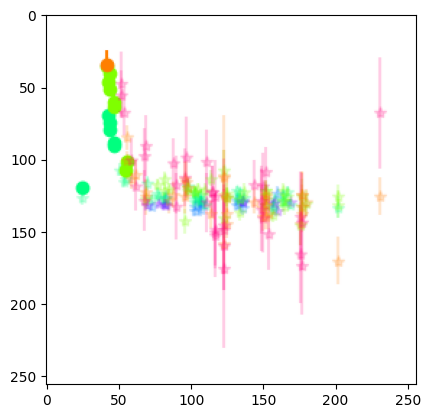

In [9]:
# part 2: running inference
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

classifier_test.model.eval()
classifier_test.model.to('cpu')

num_fractions = len(fractions_list)
batch_size = 5
figs = {}  # map batch index -> (fig, axes)

prediction_df = pd.DataFrame()

for frac, fractional_dl in zip(fractions_list, test_dataloaders):
    for index, batch in enumerate(fractional_dl):
        batch = {k: v.to('cpu') if torch.is_tensor(v) else v for k, v in batch.items()}
        
        print(batch['static'])
        
        prediction_df = classifier_test.model.predict_class_probabilities_df(batch)
        print(f'Prediction for object {index} with {frac * 100}% of lightcurve: {str(prediction_df.iloc[:, 7:].idxmax(axis=1))[5:-14]}')
        
        if int(frac) == 1:
            lc_plot = torch.squeeze(batch['lc_plot'].cpu().to(torch.int32), dim=0).permute(1, 2, 0)    
            plt.imshow(lc_plot.numpy())
            
            display(prediction_df)
            # print(f'Prediction for object {index} with {frac * 100}% of lightcurve: {pred_df}')
            break

In [13]:
# creating an example train/test/validation/pool sets with no overlaps
from typing import Literal, Dict
import random
from notebook_utils import partition_dataset_by_snid, generate_dataset

# partitioning the parquet files so that our train, test, val, pool sets don't have any overlap
partitions = partition_dataset_by_snid(per_class_object_counts=100, random_seed=42,
                                       train_split=0.4, val_split=0.1, test_split=0.1, pool_split=0.4)

# generating each dataset using its partition
generate_dataset(
    dataset_type='train', 
    snid_partitions=partitions['train'],
    final_dataset_file='./datasets/training_set.parquet'
)

generate_dataset(
    dataset_type='val', 
    snid_partitions=partitions['val'],
    final_dataset_file='./datasets/val_set.parquet'
)

generate_dataset(
    dataset_type='test', 
    snid_partitions=partitions['test'],
    final_dataset_file='./datasets/test_set.parquet'
)

generate_dataset(
    dataset_type='pool', 
    snid_partitions=partitions['pool'],
    final_dataset_file='./datasets/pool_set.parquet'
)

uLens-Single_PyLIMA.parquet: train=40, val=10, test=10, pool=40
TDE.parquet: train=40, val=10, test=10, pool=40
SNIcBL+HostXT_V19.parquet: train=40, val=10, test=10, pool=40
KN_B19.parquet: train=40, val=10, test=10, pool=40
uLens-Binary.parquet: train=40, val=10, test=10, pool=40
SNIc-Templates.parquet: train=40, val=10, test=10, pool=40
SLSN-I+host.parquet: train=40, val=10, test=10, pool=40
SNIa-SALT3.parquet: train=40, val=10, test=10, pool=40
d-Sct.parquet: train=40, val=10, test=10, pool=40
SNIb-Templates.parquet: train=40, val=10, test=10, pool=40
SNII+HostXT_V19.parquet: train=40, val=10, test=10, pool=40
SNIa-91bg.parquet: train=40, val=10, test=10, pool=40
Mdwarf-flare.parquet: train=40, val=10, test=10, pool=40
ILOT.parquet: train=40, val=10, test=10, pool=40
CLAGN.parquet: train=40, val=10, test=10, pool=40
KN_K17.parquet: train=40, val=10, test=10, pool=40
CART.parquet: train=40, val=10, test=10, pool=40
SNIIb+HostXT_V19.parquet: train=40, val=10, test=10, pool=40
SNIb+Hos

INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_uLens-Single_PyLIMA.parquet.parquet


✓ Processed uLens-Single_PyLIMA.parquet with 40 objects

Processing TDE.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_TDE.parquet.parquet


✓ Processed TDE.parquet with 40 objects

Processing SNIcBL+HostXT_V19.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_SNIcBL+HostXT_V19.parquet.parquet


✓ Processed SNIcBL+HostXT_V19.parquet with 40 objects

Processing KN_B19.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_KN_B19.parquet.parquet


✓ Processed KN_B19.parquet with 40 objects

Processing uLens-Binary.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_uLens-Binary.parquet.parquet


✓ Processed uLens-Binary.parquet with 40 objects

Processing SNIc-Templates.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_SNIc-Templates.parquet.parquet


✓ Processed SNIc-Templates.parquet with 40 objects

Processing SLSN-I+host.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_SLSN-I+host.parquet.parquet


✓ Processed SLSN-I+host.parquet with 40 objects

Processing SNIa-SALT3.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_SNIa-SALT3.parquet.parquet


✓ Processed SNIa-SALT3.parquet with 40 objects

Processing d-Sct.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_d-Sct.parquet.parquet


✓ Processed d-Sct.parquet with 40 objects

Processing SNIb-Templates.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_SNIb-Templates.parquet.parquet


✓ Processed SNIb-Templates.parquet with 40 objects

Processing SNII+HostXT_V19.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_SNII+HostXT_V19.parquet.parquet


✓ Processed SNII+HostXT_V19.parquet with 40 objects

Processing SNIa-91bg.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_SNIa-91bg.parquet.parquet


✓ Processed SNIa-91bg.parquet with 40 objects

Processing Mdwarf-flare.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_Mdwarf-flare.parquet.parquet


✓ Processed Mdwarf-flare.parquet with 40 objects

Processing ILOT.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_ILOT.parquet.parquet


✓ Processed ILOT.parquet with 40 objects

Processing CLAGN.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_CLAGN.parquet.parquet


✓ Processed CLAGN.parquet with 40 objects

Processing KN_K17.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_KN_K17.parquet.parquet


✓ Processed KN_K17.parquet with 40 objects

Processing CART.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_CART.parquet.parquet


✓ Processed CART.parquet with 40 objects

Processing SNIIb+HostXT_V19.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_SNIIb+HostXT_V19.parquet.parquet


✓ Processed SNIIb+HostXT_V19.parquet with 40 objects

Processing SNIb+HostXT_V19.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_SNIb+HostXT_V19.parquet.parquet


✓ Processed SNIb+HostXT_V19.parquet with 40 objects

Processing SNII-NMF.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_SNII-NMF.parquet.parquet


✓ Processed SNII-NMF.parquet with 40 objects

Processing SNIIn+HostXT_V19.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_SNIIn+HostXT_V19.parquet.parquet


✓ Processed SNIIn+HostXT_V19.parquet with 40 objects

Processing SNII-Templates.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_SNII-Templates.parquet.parquet


✓ Processed SNII-Templates.parquet with 40 objects

Processing SNIc+HostXT_V19.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_SNIc+HostXT_V19.parquet.parquet


✓ Processed SNIc+HostXT_V19.parquet with 40 objects

Processing Cepheid.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_Cepheid.parquet.parquet


✓ Processed Cepheid.parquet with 40 objects

Processing SNIax.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_SNIax.parquet.parquet


✓ Processed SNIax.parquet with 40 objects

Processing EB.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_EB.parquet.parquet


✓ Processed EB.parquet with 40 objects

Processing SNIIn-MOSFIT.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_SNIIn-MOSFIT.parquet.parquet


✓ Processed SNIIn-MOSFIT.parquet with 40 objects

Processing uLens-Single-GenLens.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_uLens-Single-GenLens.parquet.parquet


✓ Processed uLens-Single-GenLens.parquet with 40 objects

Processing RRL.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_RRL.parquet.parquet


✓ Processed RRL.parquet with 40 objects

Processing SLSN-I_no_host.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_SLSN-I_no_host.parquet.parquet


✓ Processed SLSN-I_no_host.parquet with 40 objects

Processing dwarf-nova.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_dwarf-nova.parquet.parquet


✓ Processed dwarf-nova.parquet with 40 objects

Processing PISN.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_train_PISN.parquet.parquet


✓ Processed PISN.parquet with 40 objects

✓ Saved train set with 1280 total objects to ./datasets/training_set.parquet

Processing uLens-Single_PyLIMA.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_uLens-Single_PyLIMA.parquet.parquet


✓ Processed uLens-Single_PyLIMA.parquet with 10 objects

Processing TDE.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_TDE.parquet.parquet


✓ Processed TDE.parquet with 10 objects

Processing SNIcBL+HostXT_V19.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_SNIcBL+HostXT_V19.parquet.parquet


✓ Processed SNIcBL+HostXT_V19.parquet with 10 objects

Processing KN_B19.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_KN_B19.parquet.parquet


✓ Processed KN_B19.parquet with 10 objects

Processing uLens-Binary.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_uLens-Binary.parquet.parquet


✓ Processed uLens-Binary.parquet with 10 objects

Processing SNIc-Templates.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_SNIc-Templates.parquet.parquet


✓ Processed SNIc-Templates.parquet with 10 objects

Processing SLSN-I+host.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_SLSN-I+host.parquet.parquet


✓ Processed SLSN-I+host.parquet with 10 objects

Processing SNIa-SALT3.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_SNIa-SALT3.parquet.parquet


✓ Processed SNIa-SALT3.parquet with 10 objects

Processing d-Sct.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_d-Sct.parquet.parquet


✓ Processed d-Sct.parquet with 10 objects

Processing SNIb-Templates.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_SNIb-Templates.parquet.parquet


✓ Processed SNIb-Templates.parquet with 10 objects

Processing SNII+HostXT_V19.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_SNII+HostXT_V19.parquet.parquet


✓ Processed SNII+HostXT_V19.parquet with 10 objects

Processing SNIa-91bg.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_SNIa-91bg.parquet.parquet


✓ Processed SNIa-91bg.parquet with 10 objects

Processing Mdwarf-flare.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_Mdwarf-flare.parquet.parquet


✓ Processed Mdwarf-flare.parquet with 10 objects

Processing ILOT.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_ILOT.parquet.parquet


✓ Processed ILOT.parquet with 10 objects

Processing CLAGN.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_CLAGN.parquet.parquet


✓ Processed CLAGN.parquet with 10 objects

Processing KN_K17.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_KN_K17.parquet.parquet


✓ Processed KN_K17.parquet with 10 objects

Processing CART.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_CART.parquet.parquet


✓ Processed CART.parquet with 10 objects

Processing SNIIb+HostXT_V19.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_SNIIb+HostXT_V19.parquet.parquet


✓ Processed SNIIb+HostXT_V19.parquet with 10 objects

Processing SNIb+HostXT_V19.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_SNIb+HostXT_V19.parquet.parquet


✓ Processed SNIb+HostXT_V19.parquet with 10 objects

Processing SNII-NMF.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_SNII-NMF.parquet.parquet


✓ Processed SNII-NMF.parquet with 10 objects

Processing SNIIn+HostXT_V19.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_SNIIn+HostXT_V19.parquet.parquet


✓ Processed SNIIn+HostXT_V19.parquet with 10 objects

Processing SNII-Templates.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_SNII-Templates.parquet.parquet


✓ Processed SNII-Templates.parquet with 10 objects

Processing SNIc+HostXT_V19.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_SNIc+HostXT_V19.parquet.parquet


✓ Processed SNIc+HostXT_V19.parquet with 10 objects

Processing Cepheid.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_Cepheid.parquet.parquet


✓ Processed Cepheid.parquet with 10 objects

Processing SNIax.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_SNIax.parquet.parquet


✓ Processed SNIax.parquet with 10 objects

Processing EB.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_EB.parquet.parquet


✓ Processed EB.parquet with 10 objects

Processing SNIIn-MOSFIT.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_SNIIn-MOSFIT.parquet.parquet


✓ Processed SNIIn-MOSFIT.parquet with 10 objects

Processing uLens-Single-GenLens.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_uLens-Single-GenLens.parquet.parquet


✓ Processed uLens-Single-GenLens.parquet with 10 objects

Processing RRL.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_RRL.parquet.parquet


✓ Processed RRL.parquet with 10 objects

Processing SLSN-I_no_host.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_SLSN-I_no_host.parquet.parquet


✓ Processed SLSN-I_no_host.parquet with 10 objects

Processing dwarf-nova.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_dwarf-nova.parquet.parquet


✓ Processed dwarf-nova.parquet with 10 objects

Processing PISN.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_val_PISN.parquet.parquet


✓ Processed PISN.parquet with 10 objects

✓ Saved val set with 320 total objects to ./datasets/val_set.parquet

Processing uLens-Single_PyLIMA.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_uLens-Single_PyLIMA.parquet.parquet


✓ Processed uLens-Single_PyLIMA.parquet with 10 objects

Processing TDE.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_TDE.parquet.parquet


✓ Processed TDE.parquet with 10 objects

Processing SNIcBL+HostXT_V19.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_SNIcBL+HostXT_V19.parquet.parquet


✓ Processed SNIcBL+HostXT_V19.parquet with 10 objects

Processing KN_B19.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_KN_B19.parquet.parquet


✓ Processed KN_B19.parquet with 10 objects

Processing uLens-Binary.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_uLens-Binary.parquet.parquet


✓ Processed uLens-Binary.parquet with 10 objects

Processing SNIc-Templates.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_SNIc-Templates.parquet.parquet


✓ Processed SNIc-Templates.parquet with 10 objects

Processing SLSN-I+host.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_SLSN-I+host.parquet.parquet


✓ Processed SLSN-I+host.parquet with 10 objects

Processing SNIa-SALT3.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_SNIa-SALT3.parquet.parquet


✓ Processed SNIa-SALT3.parquet with 10 objects

Processing d-Sct.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_d-Sct.parquet.parquet


✓ Processed d-Sct.parquet with 10 objects

Processing SNIb-Templates.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_SNIb-Templates.parquet.parquet


✓ Processed SNIb-Templates.parquet with 10 objects

Processing SNII+HostXT_V19.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_SNII+HostXT_V19.parquet.parquet


✓ Processed SNII+HostXT_V19.parquet with 10 objects

Processing SNIa-91bg.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_SNIa-91bg.parquet.parquet


✓ Processed SNIa-91bg.parquet with 10 objects

Processing Mdwarf-flare.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_Mdwarf-flare.parquet.parquet


✓ Processed Mdwarf-flare.parquet with 10 objects

Processing ILOT.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_ILOT.parquet.parquet


✓ Processed ILOT.parquet with 10 objects

Processing CLAGN.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_CLAGN.parquet.parquet


✓ Processed CLAGN.parquet with 10 objects

Processing KN_K17.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_KN_K17.parquet.parquet


✓ Processed KN_K17.parquet with 10 objects

Processing CART.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_CART.parquet.parquet


✓ Processed CART.parquet with 10 objects

Processing SNIIb+HostXT_V19.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_SNIIb+HostXT_V19.parquet.parquet


✓ Processed SNIIb+HostXT_V19.parquet with 10 objects

Processing SNIb+HostXT_V19.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_SNIb+HostXT_V19.parquet.parquet


✓ Processed SNIb+HostXT_V19.parquet with 10 objects

Processing SNII-NMF.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_SNII-NMF.parquet.parquet


✓ Processed SNII-NMF.parquet with 10 objects

Processing SNIIn+HostXT_V19.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_SNIIn+HostXT_V19.parquet.parquet


✓ Processed SNIIn+HostXT_V19.parquet with 10 objects

Processing SNII-Templates.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_SNII-Templates.parquet.parquet


✓ Processed SNII-Templates.parquet with 10 objects

Processing SNIc+HostXT_V19.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_SNIc+HostXT_V19.parquet.parquet


✓ Processed SNIc+HostXT_V19.parquet with 10 objects

Processing Cepheid.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_Cepheid.parquet.parquet


✓ Processed Cepheid.parquet with 10 objects

Processing SNIax.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_SNIax.parquet.parquet


✓ Processed SNIax.parquet with 10 objects

Processing EB.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_EB.parquet.parquet


✓ Processed EB.parquet with 10 objects

Processing SNIIn-MOSFIT.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_SNIIn-MOSFIT.parquet.parquet


✓ Processed SNIIn-MOSFIT.parquet with 10 objects

Processing uLens-Single-GenLens.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_uLens-Single-GenLens.parquet.parquet


✓ Processed uLens-Single-GenLens.parquet with 10 objects

Processing RRL.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_RRL.parquet.parquet


✓ Processed RRL.parquet with 10 objects

Processing SLSN-I_no_host.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_SLSN-I_no_host.parquet.parquet


✓ Processed SLSN-I_no_host.parquet with 10 objects

Processing dwarf-nova.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_dwarf-nova.parquet.parquet


✓ Processed dwarf-nova.parquet with 10 objects

Processing PISN.parquet (10 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_test_PISN.parquet.parquet


✓ Processed PISN.parquet with 10 objects

✓ Saved test set with 320 total objects to ./datasets/test_set.parquet

Processing uLens-Single_PyLIMA.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_uLens-Single_PyLIMA.parquet.parquet


✓ Processed uLens-Single_PyLIMA.parquet with 40 objects

Processing TDE.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_TDE.parquet.parquet


✓ Processed TDE.parquet with 40 objects

Processing SNIcBL+HostXT_V19.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_SNIcBL+HostXT_V19.parquet.parquet


✓ Processed SNIcBL+HostXT_V19.parquet with 40 objects

Processing KN_B19.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_KN_B19.parquet.parquet


✓ Processed KN_B19.parquet with 40 objects

Processing uLens-Binary.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_uLens-Binary.parquet.parquet


✓ Processed uLens-Binary.parquet with 40 objects

Processing SNIc-Templates.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_SNIc-Templates.parquet.parquet


✓ Processed SNIc-Templates.parquet with 40 objects

Processing SLSN-I+host.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_SLSN-I+host.parquet.parquet


✓ Processed SLSN-I+host.parquet with 40 objects

Processing SNIa-SALT3.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_SNIa-SALT3.parquet.parquet


✓ Processed SNIa-SALT3.parquet with 40 objects

Processing d-Sct.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_d-Sct.parquet.parquet


✓ Processed d-Sct.parquet with 40 objects

Processing SNIb-Templates.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_SNIb-Templates.parquet.parquet


✓ Processed SNIb-Templates.parquet with 40 objects

Processing SNII+HostXT_V19.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_SNII+HostXT_V19.parquet.parquet


✓ Processed SNII+HostXT_V19.parquet with 40 objects

Processing SNIa-91bg.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_SNIa-91bg.parquet.parquet


✓ Processed SNIa-91bg.parquet with 40 objects

Processing Mdwarf-flare.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_Mdwarf-flare.parquet.parquet


✓ Processed Mdwarf-flare.parquet with 40 objects

Processing ILOT.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_ILOT.parquet.parquet


✓ Processed ILOT.parquet with 40 objects

Processing CLAGN.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_CLAGN.parquet.parquet


✓ Processed CLAGN.parquet with 40 objects

Processing KN_K17.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_KN_K17.parquet.parquet


✓ Processed KN_K17.parquet with 40 objects

Processing CART.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_CART.parquet.parquet


✓ Processed CART.parquet with 40 objects

Processing SNIIb+HostXT_V19.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_SNIIb+HostXT_V19.parquet.parquet


✓ Processed SNIIb+HostXT_V19.parquet with 40 objects

Processing SNIb+HostXT_V19.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_SNIb+HostXT_V19.parquet.parquet


✓ Processed SNIb+HostXT_V19.parquet with 40 objects

Processing SNII-NMF.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_SNII-NMF.parquet.parquet


✓ Processed SNII-NMF.parquet with 40 objects

Processing SNIIn+HostXT_V19.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_SNIIn+HostXT_V19.parquet.parquet


✓ Processed SNIIn+HostXT_V19.parquet with 40 objects

Processing SNII-Templates.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_SNII-Templates.parquet.parquet


✓ Processed SNII-Templates.parquet with 40 objects

Processing SNIc+HostXT_V19.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_SNIc+HostXT_V19.parquet.parquet


✓ Processed SNIc+HostXT_V19.parquet with 40 objects

Processing Cepheid.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_Cepheid.parquet.parquet


✓ Processed Cepheid.parquet with 40 objects

Processing SNIax.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_SNIax.parquet.parquet


✓ Processed SNIax.parquet with 40 objects

Processing EB.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_EB.parquet.parquet


✓ Processed EB.parquet with 40 objects

Processing SNIIn-MOSFIT.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_SNIIn-MOSFIT.parquet.parquet


✓ Processed SNIIn-MOSFIT.parquet with 40 objects

Processing uLens-Single-GenLens.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_uLens-Single-GenLens.parquet.parquet


✓ Processed uLens-Single-GenLens.parquet with 40 objects

Processing RRL.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_RRL.parquet.parquet


✓ Processed RRL.parquet with 40 objects

Processing SLSN-I_no_host.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_SLSN-I_no_host.parquet.parquet


✓ Processed SLSN-I_no_host.parquet with 40 objects

Processing dwarf-nova.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_dwarf-nova.parquet.parquet


✓ Processed dwarf-nova.parquet with 40 objects

Processing PISN.parquet (40 objects)...


INFO:root:Starting oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor fit...
INFO:root:Features have been saved to: ./datasets/intermediate_pool_PISN.parquet.parquet


✓ Processed PISN.parquet with 40 objects

✓ Saved pool set with 1280 total objects to ./datasets/pool_set.parquet


In [ ]:
from resspect import TimeDomainConfiguration, time_domain_loop

def run_td_loop(day):
    # define parameters for TimeDomainConfiguration class
    feature_extraction_method = 'oracle_resspect_classifier.elasticc2_oracle_feature_extractor.ELAsTiCC2_ORACLEFeatureExtractor'
    classifier = 'oracle_resspect_classifier.oracle_classifier.OracleResspectClassifier'
    
    days = [] # figure this out
    training = None
    
    strategy = 'UncertaintySampling'
    batch = 5
    sep_files = True
    path_to_features_dir = './datasets'
    
    # output results for metrics
    output_metrics_file = './results/metrics_' + strategy + '_' + str('ini_train_set') + '_batch' + str(batch) + '_day_' + str(day) + '.csv'
    
    # output query sample
    output_query_file = './results/queried_' + strategy + '_' + str('ini_train_set') + '_batch' + str(batch) + '_day_' + str(day) + '.csv'
    
    path_to_ini_files = {}
    path_to_ini_files['train'] = './datasets/training_set.parquet'
    path_to_ini_files['test'] = './datasets/test_set.parquet'
    path_to_ini_files['validation'] = './datasets/val_set.parquet'
    
    survey = 'LSST'
    
    fname_pattern = [''] # figure this out as well
    queryable = False
    
    time_domain_config = TimeDomainConfiguration(
        days=days, output_metrics_file=output_metrics_file, output_queried_file=output_query_file, path_to_features_dir=path_to_features_dir,
        strategy=strategy, fname_pattern=fname_pattern, path_to_ini_files=path_to_ini_files, batch=batch, classifier=classifier,
        sep_files=sep_files, survey=survey, feature_extraction_method=feature_extraction_method
    )
    
    # run time domain active learning loop
    time_domain_loop(time_domain_config, screen=False)
    
    # grab the object ids for the returned objects (to be queried)
    ids = list(pd.read_csv(output_query_file)['objectid'])
    ids = [int(id) for id in ids]
    num = int(len(ids)/5)
    mod = len(ids)%5
    num_list = [num]*5
    mod_list = []
    for i in range(mod):
        mod_list.append(1)
    rem = 5-len(mod_list)
    mod_list = mod_list+[0]*rem
    num_list=list(np.asarray(num_list)+mod_list)
    priorities = []
    priorities.append([1]*num_list[0]+[2]*num_list[1]+[3]*num_list[2]+[4]*num_list[3]+[5]*num_list[4])    
    priorities = priorities[0]
    
    # send these queried objects to the TOM
    # submit_queries_to_TOM('awoldag', '../../password.txt', objectids = ids, priorities = priorities, requester = 'resspect')
    print(ids, priorities)

In [ ]:
# for the objects to be queried, get the spectra and classification label
# also get the photometry to corresponds to those objects

In [ ]:
# add those objects to the parquet file for the training set
# and remove those objects from the parquet file for the pool set

In [ ]:
# do this classification for a few hundred of each object type and remake the confusion matrices to see if results match what we expect
# work on resspect PR for supporting parquet as well as csv files
# integrate classification into the full TimeDomainLoop infrastructure